In [6]:
!pip install datasets
!pip install --upgrade pyarrow
#!pip install -U sentence-transformers
#!pip install faiss-cpu
#!pip install -U transformers sentence-transformers


#!pip install pyarrow==12.0.1
#!pip install --upgrade datasets
!pip install sentence-transformers
!pip install faiss-cpu
!pip install transformers


In [3]:
from pyspark.sql import SparkSession
from datasets import load_dataset, load_dataset_builder
import subprocess

In [4]:
spark = SparkSession.builder \
    .appName("AmazonReviewsRead") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/06 12:15:53 INFO SparkEnv: Registering MapOutputTracker
25/05/06 12:15:53 INFO SparkEnv: Registering BlockManagerMaster
25/05/06 12:15:53 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/05/06 12:15:53 INFO SparkEnv: Registering OutputCommitCoordinator


In [5]:
user_reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", split="full", trust_remote_code=True)
item_metadata = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full", trust_remote_code=True)

In [6]:
#print(user_reviews["full"][0])

In [7]:
print(item_metadata[0])

{'main_category': 'All Beauty', 'title': 'Howard LC0008 Leather Conditioner, 8-Ounce (4-Pack)', 'average_rating': 4.8, 'rating_number': 10, 'features': [], 'description': [], 'price': 'None', 'images': {'hi_res': [None, 'https://m.media-amazon.com/images/I/71i77AuI9xL._SL1500_.jpg'], 'large': ['https://m.media-amazon.com/images/I/41qfjSfqNyL.jpg', 'https://m.media-amazon.com/images/I/41w2yznfuZL.jpg'], 'thumb': ['https://m.media-amazon.com/images/I/41qfjSfqNyL._SS40_.jpg', 'https://m.media-amazon.com/images/I/41w2yznfuZL._SS40_.jpg'], 'variant': ['MAIN', 'PT01']}, 'videos': {'title': [], 'url': [], 'user_id': []}, 'store': 'Howard Products', 'categories': [], 'details': '{"Package Dimensions": "7.1 x 5.5 x 3 inches; 2.38 Pounds", "UPC": "617390882781"}', 'parent_asin': 'B01CUPMQZE', 'bought_together': None, 'subtitle': None, 'author': None}


In [8]:
user_reviews.to_json("user_reviews.jsonl", orient="records", lines=True)
item_metadata.to_json("item_metadata.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/702 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/113 [00:00<?, ?ba/s]

206804886

In [9]:
# push the data onto HDFS and check the folder 
!hadoop fs -put user_reviews.jsonl /user/hdfs/raw_review_All_Beauty.jsonl
!hadoop fs -put item_metadata.jsonl /user/hdfs/raw_meta_All_Beauty.jsonl
!hadoop fs -ls /user/hdfs

put: `/user/hdfs/raw_review_All_Beauty.jsonl': File exists
put: `/user/hdfs/raw_meta_All_Beauty.jsonl': File exists
Found 2 items
-rw-r--r--   2 root hadoop  206804886 2025-05-06 11:58 /user/hdfs/raw_meta_All_Beauty.jsonl
-rw-r--r--   2 root hadoop  314275749 2025-05-06 11:57 /user/hdfs/raw_review_All_Beauty.jsonl


In [10]:
!hadoop fs -cat /user/hdfs/raw_review_All_Beauty.jsonl | head -n 5


{"rating":5.0,"title":"Such a lovely scent but not overpowering.","text":"This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!","images":[],"asin":"B00YQ6X8EO","parent_asin":"B00YQ6X8EO","user_id":"AGKHLEW2SOWHNMFQIJGBECAF7INQ","timestamp":1588687728923,"helpful_vote":0,"verified_purchase":true}
{"rating":4.0,"title":"Works great but smells a little weird.","text":"This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was described but I was hoping it would be light)","images":[],"asin":"B081TJ8YS3","parent_asin":"B081TJ8YS3","user_id":"AGKHLEW2SOWHNMFQIJGBECAF7INQ","timestamp":1588615855070,"helpful_vote":1,"ver

In [11]:
!hadoop fs -cat /user/hdfs/raw_meta_All_Beauty.jsonl | head -n 5

{"main_category":"All Beauty","title":"Howard LC0008 Leather Conditioner, 8-Ounce (4-Pack)","average_rating":4.8,"rating_number":10,"features":[],"description":[],"price":"None","images":{"hi_res":[null,"https:\/\/m.media-amazon.com\/images\/I\/71i77AuI9xL._SL1500_.jpg"],"large":["https:\/\/m.media-amazon.com\/images\/I\/41qfjSfqNyL.jpg","https:\/\/m.media-amazon.com\/images\/I\/41w2yznfuZL.jpg"],"thumb":["https:\/\/m.media-amazon.com\/images\/I\/41qfjSfqNyL._SS40_.jpg","https:\/\/m.media-amazon.com\/images\/I\/41w2yznfuZL._SS40_.jpg"],"variant":["MAIN","PT01"]},"videos":{"title":[],"url":[],"user_id":[]},"store":"Howard Products","categories":[],"details":"{\"Package Dimensions\": \"7.1 x 5.5 x 3 inches; 2.38 Pounds\", \"UPC\": \"617390882781\"}","parent_asin":"B01CUPMQZE","bought_together":null,"subtitle":null,"author":null}
{"main_category":"All Beauty","title":"Yes to Tomatoes Detoxifying Charcoal Cleanser (Pack of 2) with Charcoal Powder, Tomato Fruit Extract, and Gingko Biloba Le

In [12]:
df_user_review = spark.read.json("hdfs:///user/hdfs/raw_review_All_Beauty.jsonl")
df_user_review.printSchema()
df_user_review.show(2)

root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)

+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+-

In [13]:
df_item_metadata = spark.read.json("hdfs:///user/hdfs/raw_meta_All_Beauty.jsonl")
df_item_metadata.printSchema()
df_item_metadata.show(1)

root
 |-- author: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- bought_together: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- images: struct (nullable = true)
 |    |-- hi_res: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- large: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- thumb: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- variant: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- main_category: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rating_numbe

In [11]:
# total comment counts 
df_user_review.count()

701528

In [12]:
# rating distributions
df_user_review.groupBy("rating").count().orderBy("rating").show()

+------+------+
|rating| count|
+------+------+
|   1.0|102080|
|   2.0| 43034|
|   3.0| 56307|
|   4.0| 79381|
|   5.0|420726|
+------+------+



In [13]:
# verified purchase distribution 
df_user_review.groupBy("verified_purchase").count().show()

+-----------------+------+
|verified_purchase| count|
+-----------------+------+
|             true|634969|
|            false| 66559|
+-----------------+------+



# EDA
## I. USER REVIEW DATASET EDA

In [14]:
from pyspark.sql.functions import col, length, when, avg, count
import matplotlib.pyplot as plt

In [17]:
# 1. Basic Info
df_user_review.printSchema()
print(f"Total user reviews: {df_user_review.count()}")
df_user_review.select([col(c).isNull().alias(c) for c in df_user_review.columns]).summary("count").show()

root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)



Total user reviews: 701528
+-------+
|summary|
+-------+
|  count|
+-------+



In [18]:
# 2. Unique Users and Items
print("Unique users:", df_user_review.select("user_id").distinct().count())
print("Unique items:", df_user_review.select("asin").distinct().count())

Unique users: 631986


Unique items: 115709


The dataset contains 631,986 unique users and 115,709 unique items, indicating a large and diverse set of user interactions with beauty products.

In [20]:
# 3. Most Reviewed Items
df_user_review.groupBy("asin").count().orderBy("count", ascending=False).show(10)

+----------+-----+
|      asin|count|
+----------+-----+
|B007IAE5WY| 1962|
|B00EEN2HCS| 1750|
|B07C533XCW| 1513|
|B00R1TAN7I| 1372|
|B08L5KN7X4| 1343|
|B019GBG0IE| 1328|
|B0719KWG8H| 1168|
|B0092MCQZ4| 1128|
|B0107QYW14| 1112|
|B0070Z7KME|  934|
+----------+-----+
only showing top 10 rows



The top 10 most reviewed items in the dataset are led by B007IAE5WY with 1,962 reviews, followed by other popular items like B00EEN2HCS and B07C533XCW,

In [21]:
# 4. Users with Most Reviews
df_user_review.groupBy("user_id").count().orderBy("count", ascending=False).show(10)

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|AG73BVBKUOH22USSF...|  165|
|AEZP6Z2C5AVQDZAJE...|  146|
|AEMP3A7IKW37CMWFX...|  115|
|AHDVSLWHSORYGG3S5...|  108|
|AGZUJTI7A3JFKB4FP...|   87|
|AFDYIK3FNPY2JFBQY...|   83|
|AFXF3EGQTQDXMRLDW...|   81|
|AEJU3Z6HDAERETMYI...|   79|
|AHY2TURQPNIDXZGH2...|   69|
|AEOK4TQIKGO23SJKZ...|   68|
+--------------------+-----+
only showing top 10 rows



In [22]:
# 5. Average Rating per Item
df_user_review.groupBy("asin").avg("rating").orderBy("avg(rating)", ascending=False).show(20)

+----------+-----------+
|      asin|avg(rating)|
+----------+-----------+
|B07GVS2FMN|        5.0|
|B001B829SQ|        5.0|
|B089RLCQ5Z|        5.0|
|B07KS6Y9B2|        5.0|
|B0798W964Q|        5.0|
|B098T1BQG4|        5.0|
|B00JRDE7U0|        5.0|
|B00020UR4C|        5.0|
|B07YW7J2WX|        5.0|
|B088PMZYS4|        5.0|
|B01GD8VZII|        5.0|
|B00IH125HA|        5.0|
|B07JJ93KXV|        5.0|
|B09VV9KC77|        5.0|
|B08F1J2HLN|        5.0|
|B08ZN3WZM9|        5.0|
|B08GL5WGGM|        5.0|
|B00ENSUY5G|        5.0|
|B071CPQRTM|        5.0|
|B09C73WYDR|        5.0|
+----------+-----------+
only showing top 20 rows



In [26]:
# 6. Review Text Length Stats
df_user_review.select(length(col("text")).alias("review_length")).summary("mean", "min", "max").show()

+-------+------------------+
|summary|     review_length|
+-------+------------------+
|   mean|173.03164093236478|
|    min|                 0|
|    max|             14989|
+-------+------------------+



Mean review length: The average length of a review is approximately 173 characters.
Minimum review length: The shortest review has 0 characters (possibly an empty review).
Maximum review length: The longest review has 14,989 characters, which is quite extensive compared to the mean.

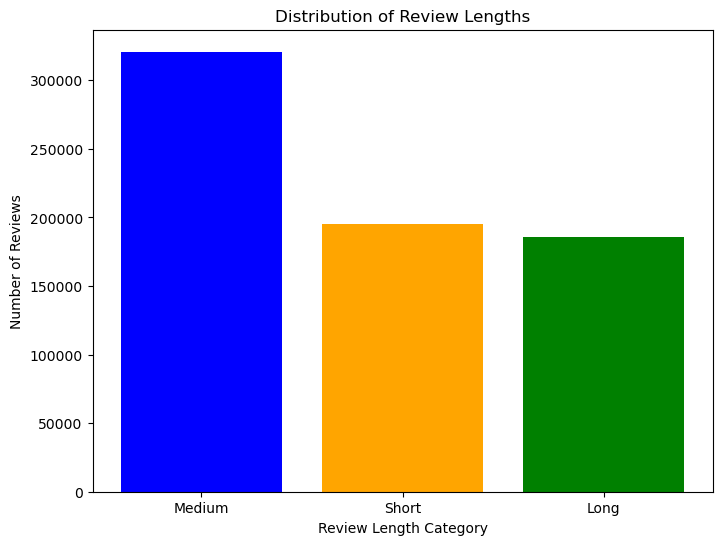

In [33]:
# 7. Review Length Category Distribution
df_user_review = df_user_review.withColumn(
    "review_length_category",
    when(length(col("text")) < 50, "Short")
    .when(length(col("text")) < 200, "Medium")
    .otherwise("Long")
)

review_length_counts = df_user_review.groupBy("review_length_category").count().orderBy("count", ascending=False).toPandas()
plt.figure(figsize=(8, 6))
plt.bar(review_length_counts['review_length_category'], review_length_counts['count'], color=['blue', 'orange', 'green'])
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length Category")
plt.ylabel("Number of Reviews")
plt.show()

In [34]:
# 8. Verified Purchase vs Rating
df_user_review.groupBy("verified_purchase").avg("rating").show()

+-----------------+-----------------+
|verified_purchase|      avg(rating)|
+-----------------+-----------------+
|             true|3.948165973456972|
|            false|4.075481903273787|
+-----------------+-----------------+



Users who made a verified purchase have an average rating of approximately 3.95.
Users who did not make a verified purchase have a slightly higher average rating of approximately 4.08.
This suggests that ratings from verified purchasers tend to be slightly lower than those from non-verified purchasers.

In [35]:
# 9. Helpful Votes Summary
df_user_review.select("helpful_vote").summary("count", "mean", "min", "max").show()

+-------+------------------+
|summary|      helpful_vote|
+-------+------------------+
|  count|            701528|
|   mean|0.9235882245612435|
|    min|                 0|
|    max|               646|
+-------+------------------+



There are a total of 701,528 entries for helpful votes.
The average number of helpful votes per review is approximately 0.92.
The minimum number of helpful votes is 0 (indicating no helpful votes for some reviews).
The maximum number of helpful votes for a review is 646.
This suggests that most reviews receive very few helpful votes, with a small number of reviews accumulating a large number of helpful votes.

In [36]:
# 10. Helpful Vote Binning
df_user_review = df_user_review.withColumn(
    "helpful_vote_bin",
    when(col("helpful_vote") == 0, "0 votes")
    .when((col("helpful_vote") > 0) & (col("helpful_vote") <= 5), "1-5 votes")
    .otherwise("6+ votes")
)
df_user_review.groupBy("helpful_vote_bin").count().orderBy("count", ascending=False).show()

+----------------+------+
|helpful_vote_bin| count|
+----------------+------+
|         0 votes|514089|
|       1-5 votes|165082|
|        6+ votes| 22357|
+----------------+------+



514,089 reviews fall into the "0 votes" bin (no helpful votes).
165,082 reviews have between 1-5 votes.
22,357 reviews have 6 or more helpful votes.
This indicates that most reviews receive little to no helpful votes, while a smaller fraction of reviews receive more significant engagement in terms of helpfulness.

In [37]:
# 11. Top Items by Verified Reviews
df_user_review.filter(col("verified_purchase") == True) \
    .groupBy("asin").count().orderBy("count", ascending=False).show(10)

+----------+-----+
|      asin|count|
+----------+-----+
|B007IAE5WY| 1887|
|B00EEN2HCS| 1719|
|B07C533XCW| 1495|
|B019GBG0IE| 1302|
|B08L5KN7X4| 1300|
|B00R1TAN7I| 1273|
|B0719KWG8H| 1117|
|B0107QYW14| 1093|
|B0092MCQZ4| 1066|
|B0070Z7KME|  896|
+----------+-----+
only showing top 10 rows



In [47]:
# 12. Correlation between Review Length and Rating
# Compute Pearson correlation between review length and rating

# Select the relevant columns
df_user_review_corr = df_user_review.select(length(col("text")).alias("review_length"), "rating")

# Compute the Pearson correlation
pearson_corr = df_user_review_corr.corr("review_length", "rating")
print(f"Pearson Correlation between review length and rating: {pearson_corr}")

Pearson Correlation between review length and rating: -0.01720969472933887


The Pearson correlation between review length and rating is -0.0172, which indicates a very weak negative relationship between the two variables. This suggests that, overall, there is almost no linear correlation between the length of a review and the rating given

+------+------+
|rating| count|
+------+------+
|   1.0|102080|
|   2.0| 43034|
|   3.0| 56307|
|   4.0| 79381|
|   5.0|420726|
+------+------+



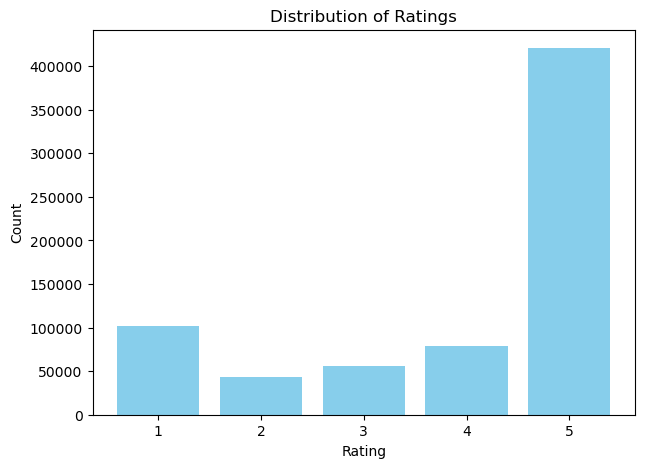

In [39]:
# 13. Distribution of Ratings
df_user_review.groupBy("rating").count().orderBy("rating").show()

ratings = df_user_review.groupBy("rating").count().toPandas()
plt.figure(figsize=(7, 5))
plt.bar(ratings['rating'], ratings['count'], color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

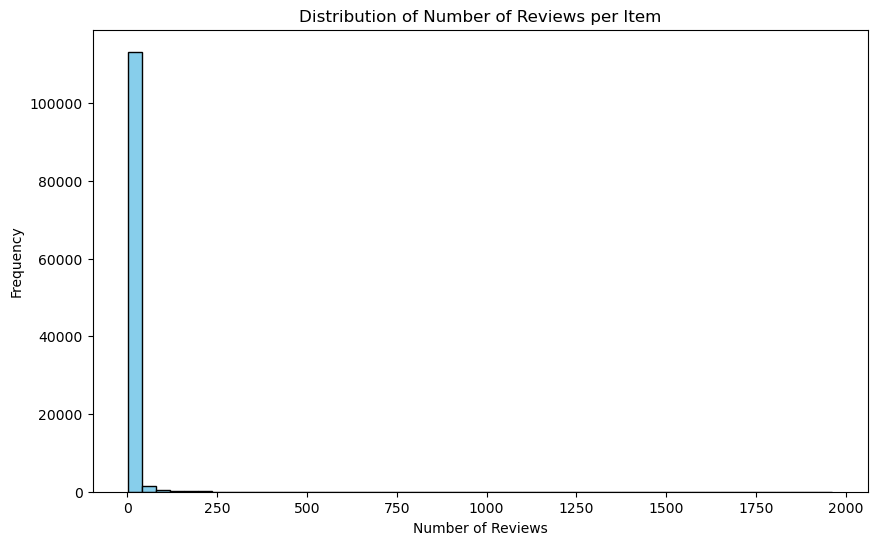

In [48]:
# 14. Distribution of Number of Reviews per Item
item_reviews_count = df_user_review.groupBy("asin").count().toPandas()

plt.figure(figsize=(10, 6))
plt.hist(item_reviews_count['count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Reviews per Item')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

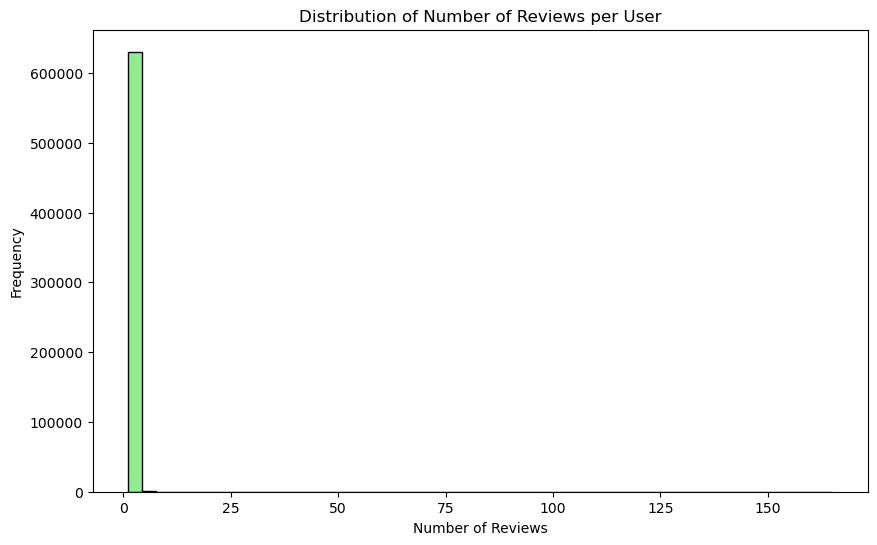

In [49]:
# 15. Distribution of Number of Reviews per User
user_reviews_count = df_user_review.groupBy("user_id").count().toPandas()

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(user_reviews_count['count'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Number of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()


## II. ITEM METADATA DATASET EDA

In [15]:
# 1. Basic Info
df_item_metadata.printSchema()
print(f"Total metadata entries: {df_item_metadata.count()}")
df_item_metadata.select([col(c).isNull().alias(c) for c in df_item_metadata.columns]).summary("count").show()

root
 |-- author: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- bought_together: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- images: struct (nullable = true)
 |    |-- hi_res: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- large: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- thumb: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- variant: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- main_category: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rating_numbe

Total metadata entries: 112590
+-------+
|summary|
+-------+
|  count|
+-------+



In [16]:
import pandas as pd
import numpy as np

# Fields to check
fields_to_check = [
    "author", "bought_together", "categories", "subtitle", "store",
    "details", "description", "average_rating", "images", "features",
    "main_category", "parent_asin", "rating_number", "price", "title", "videos"
]

# Select and convert to pandas
df_check = item_metadata.select_columns(fields_to_check).to_pandas()

# Convert numeric fields to numeric types (coerce invalids to NaN)
for col in ["price", "average_rating", "rating_number"]:
    df_check[col] = pd.to_numeric(df_check[col], errors='coerce')

def is_missing(val):
    try:
        if pd.isna(val):
            return True
        if isinstance(val, str) and val.strip().lower() in ["", "null", "none", "n/a"]:
            return True
        if isinstance(val, (list, np.ndarray, dict)) and len(val) == 0:
            return True
    except Exception:
        return False  # in case a weird type breaks things
    return False


# Apply missing logic column-wise
missing_counts = df_check.apply(lambda col: col.apply(is_missing).sum())
missing_report = missing_counts.to_frame(name='Missing Count')
missing_report['Total'] = len(df_check)
missing_report['Missing Rate (%)'] = (missing_report['Missing Count'] / missing_report['Total']) * 100

# Optional: Sort by missing rate
missing_report = missing_report.sort_values(by='Missing Rate (%)', ascending=False)

print(missing_report)


/tmp/ipykernel_27075/1862227394.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pd.isna(val):


                 Missing Count   Total  Missing Rate (%)
author                  112590  112590        100.000000
bought_together         112590  112590        100.000000
categories              112590  112590        100.000000
subtitle                112590  112590        100.000000
features                 95213  112590         84.566125
price                    94886  112590         84.275691
description              93428  112590         82.980727
store                    11337  112590         10.069278
title                       12  112590          0.010658
details                      0  112590          0.000000
average_rating               0  112590          0.000000
images                       0  112590          0.000000
parent_asin                  0  112590          0.000000
main_category                0  112590          0.000000
rating_number                0  112590          0.000000
videos                       0  112590          0.000000


Columns with all non-null values:
average_rating, categories, description, details, images, main_category, parent_asin, rating_number, title, videos

Columns with null values:
author (all nulls), bought_together (all nulls), subtitle (all nulls), categories (all nulls)

Columns with partial nulls:
features (95,213 null values, 17,377 non-null values)
price (94,886 null values, 17,704 non-null values)
description (93,428 null values, 19,162 non-null values)
store (11,337 null values, 101,259 non-null values)
title (12 null values, 112,578 non-null values)

This indicates that the dataset has significant missing information, especially in the author, bought_together, subtitle, and categories columns, which are completely null. Other fields, such as price, features, and description, have high missing rates, with over 80% of their values missing. However, columns like average_rating, rating_number, and main_category are fully populated.

In [41]:
# 2. Top Categories
df_item_metadata.groupBy("main_category").count().orderBy("count", ascending=False).show(10)

+--------------+------+
| main_category| count|
+--------------+------+
|    All Beauty|112135|
|Premium Beauty|   455|
+--------------+------+



All Beauty with 112,135 items
Premium Beauty with 455 items
This indicates that the vast majority of items fall under the "All Beauty" category, with a much smaller portion under the "Premium Beauty" category.

In [52]:
# 3. Average Rating per Category (correcting by using the 'rating' column)
df_item_metadata.join(df_user_review, df_item_metadata['parent_asin'] == df_user_review['asin']) \
    .groupBy("main_category") \
    .avg("rating") \
    .orderBy("avg(rating)", ascending=False) \
    .show()


+--------------+------------------+
| main_category|       avg(rating)|
+--------------+------------------+
|Premium Beauty| 4.030726739167961|
|    All Beauty|3.9443918259797934|
+--------------+------------------+



Premium Beauty has an average rating of 4.03.
All Beauty has an average rating of 3.94.
This indicates that products in the "Premium Beauty" category tend to have slightly higher ratings than those in the "All Beauty" category

In [53]:
# 4. Average Price per Category
df_item_metadata.groupBy("main_category").agg({"price": "avg"}).orderBy("avg(price)").show()

+--------------+------------------+
| main_category|        avg(price)|
+--------------+------------------+
|    All Beauty|  27.0899248548337|
|Premium Beauty|48.361014492753625|
+--------------+------------------+



All Beauty has an average price of 27.09 dollars.
Premium Beauty has an average price of 48.36 dollars.
This suggests that products in the "Premium Beauty" category are generally more expensive than those in the "All Beauty" category.

In [26]:
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import col, regexp_replace
from collections import Counter
import matplotlib.pyplot as plt


# Preprocess text: Remove "-" and "&" and then tokenize the titles and descriptions
def clean_text(text):
    # Remove '-' and '&' characters and extra spaces from the text
    return text.replace("-", " ").replace("&", " ").strip()

clean_text_udf = F.udf(clean_text)

# Apply the cleaning function to the 'title' column
df_item_metadata_clean = df_item_metadata.withColumn("clean_title", clean_text_udf(col("title")))

# Tokenize the cleaned titles
tokenizer = Tokenizer(inputCol="clean_title", outputCol="title_tokens")
df_tokens = tokenizer.transform(df_item_metadata_clean)

# Remove stop words
remover = StopWordsRemover(inputCol="title_tokens", outputCol="title_clean")
df_tokens_clean = remover.transform(df_tokens)

# Filter out empty strings directly after tokenization
words_rdd = df_tokens_clean.select("title_clean").rdd.flatMap(lambda x: [word for word in x[0] if word.strip() != ""])

# Count the frequency of non-empty words
word_counts = Counter(words_rdd.collect())

# Display the top 20 most common words
top_20_words = word_counts.most_common(20)
print(top_20_words)


[('hair', 76727), ('women', 19140), ('nail', 17384), ('human', 16179), ('natural', 14015), ('extensions', 12283), ('black', 11235), ('body', 10597), ('wig', 10532), ('wigs', 9997), ('bundles', 8843), ('color', 8832), ('long', 8753), ('oz', 8534), ('lace', 8140), ('makeup', 8002), ('brush', 7920), ('set', 7837), ('3', 7696), ('wave', 7437)]


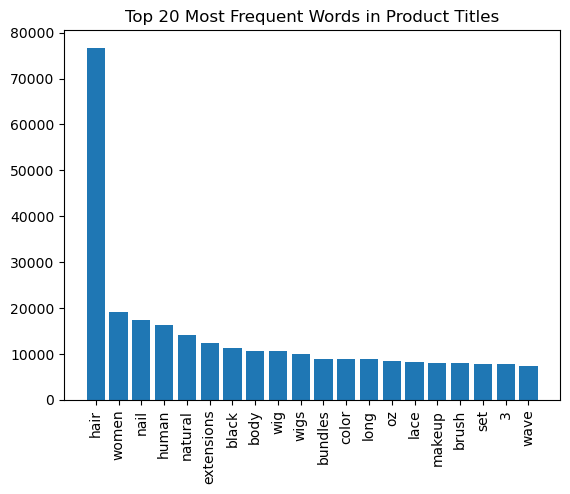

In [27]:
# Plotting the most frequent words
words, counts = zip(*top_20_words)
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words in Product Titles')
plt.show()

The most frequently occurring words in the product titles are related to haircare and beauty products, with "hair" being the most common term, followed by other key terms like "women," "nail," "human," and "natural." Words such as "wig," "extensions," and "bundles" suggest a focus on hair products, while terms like "makeup," "brush," and "set" reflect a broader beauty and cosmetics theme. Additionally, specific descriptors like "black," "color," and "long" are common, indicating that product titles often emphasize color and length attributes.